## Table of contents
1. [Introduction](#introduction)

2. [Imports, Preprocessing, Analysis](#imp-pre-anal)

3. [Initial SVM Models](#svm)

    * [Linear Kernel](#linear)
    
    * [Radial Basis Function (RBF) Kernel](#rbf)
    
    * [Polynomial Kernel](#poly)
    
4. [Finding Optimal Hyperparameters](#finetune)

    * [Linear Kernel](#tune-linear)
    
    * [Radial Basis Function (RBF) Kernel](#tune-rbf)
    
    * [Polynomial Kernel](#tune-poly)
    
5. [Optimal SVM Models](#optimal)

    * [Linear Kernel](#optimal-linear)
    
    * [Radial Basis Function (RBF) Kernel](#optimal-rbf)
    
    * [Polynomial Kernel](#optimal-poly)
    
6. [Grid Search](#grid)

7. [Summary](#summary)

## Introduction <a name="introduction"></a>

**Author:** Parthasarathi Das

**Objective:** Understand the usage of Support Vector Machines through a classification problem

**Data:** A set of voice characteristics labelled as either male or female

&emsp;&emsp;**Source:** [Kory Becker](https://www.kaggle.com/primaryobjects/voicegender)

&emsp;&emsp;**Feature Description:** Copied in verbatim from the source above

*The following acoustic properties of each voice are measured and included within the CSV:*

| Feature | Description |
|------|------|
| meanfreq | mean frequency (in kHz)| 
| sd | standard deviation of frequency| 
| median | median frequency (in kHz)| 
| Q25 | first quantile (in kHz)| 
| Q75 | third quantile (in kHz) | 
| IQR | interquantile range (in kHz) | 
| skew | skewness (see note in specprop description) |
| kurt | kurtosis (see note in specprop description) |
| sp.ent | spectral entropy |
| sfm | spectral flatness |
| mode | mode frequency |
| centroid | frequency centroid (see specprop) |
| peakf | peak frequency (frequency with highest energy) |
| meanfun | average of fundamental frequency measured across acoustic signal |
| minfun | minimum fundamental frequency measured across acoustic signal |
| maxfun | maximum fundamental frequency measured across acoustic signal |
| meandom | average of dominant frequency measured across acoustic signal |
| mindom | minimum of dominant frequency measured across acoustic signal |
| maxdom | maximum of dominant frequency measured across acoustic signal |
| dfrange | range of dominant frequency measured across acoustic signal |
| modindx | modulation index <br> Calculated as the accumulated absolute difference between adjacent <br> measurements of fundamental frequencies divided by the frequency range |
| label | male or female |

## Imports, Preprocessing, Analysis <a name="imp-pre-anal"></a>

In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [87]:
df = pd.read_csv('voice.csv', header=0)
df.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [88]:
# check for null values
df.isna().sum()

meanfreq    0
sd          0
median      0
Q25         0
Q75         0
IQR         0
skew        0
kurt        0
sp.ent      0
sfm         0
mode        0
centroid    0
meanfun     0
minfun      0
maxfun      0
meandom     0
mindom      0
maxdom      0
dfrange     0
modindx     0
label       0
dtype: int64

**Note:** 
* To detect NaN values numpy uses `np.isnan()`.
* To detect NaN values pandas uses either `.isna()` or `.isnull()`.
* The NaN values are inherited from the fact that pandas is built on top of numpy, while the two functions' names originate from R's DataFrames, whose structure and functionality pandas tried to mimic.

In [89]:
# check shape
df.shape

(3168, 21)

In [90]:
# print some label metadata
print ("Total number of labels: {}".format(df.shape[0]))
print ("Number of male labels: {}".format(df[df['label']=='male'].shape[0]))
print ("Number of female labels: {}".format(df[df['label']=='female'].shape[0]))

Total number of labels: 3168
Number of male labels: 1584
Number of female labels: 1584


In [91]:
# Scale the features
from sklearn.preprocessing import StandardScaler

X = df.iloc[:, :-1]
X = StandardScaler().fit(X).transform(X)

In [92]:
# Encode labels to int
from sklearn.preprocessing import LabelEncoder
df['label'] = LabelEncoder().fit_transform(df['label'])

# Set y to labels
y = df.iloc[:, -1]

In [93]:
# Split the dataset into train and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

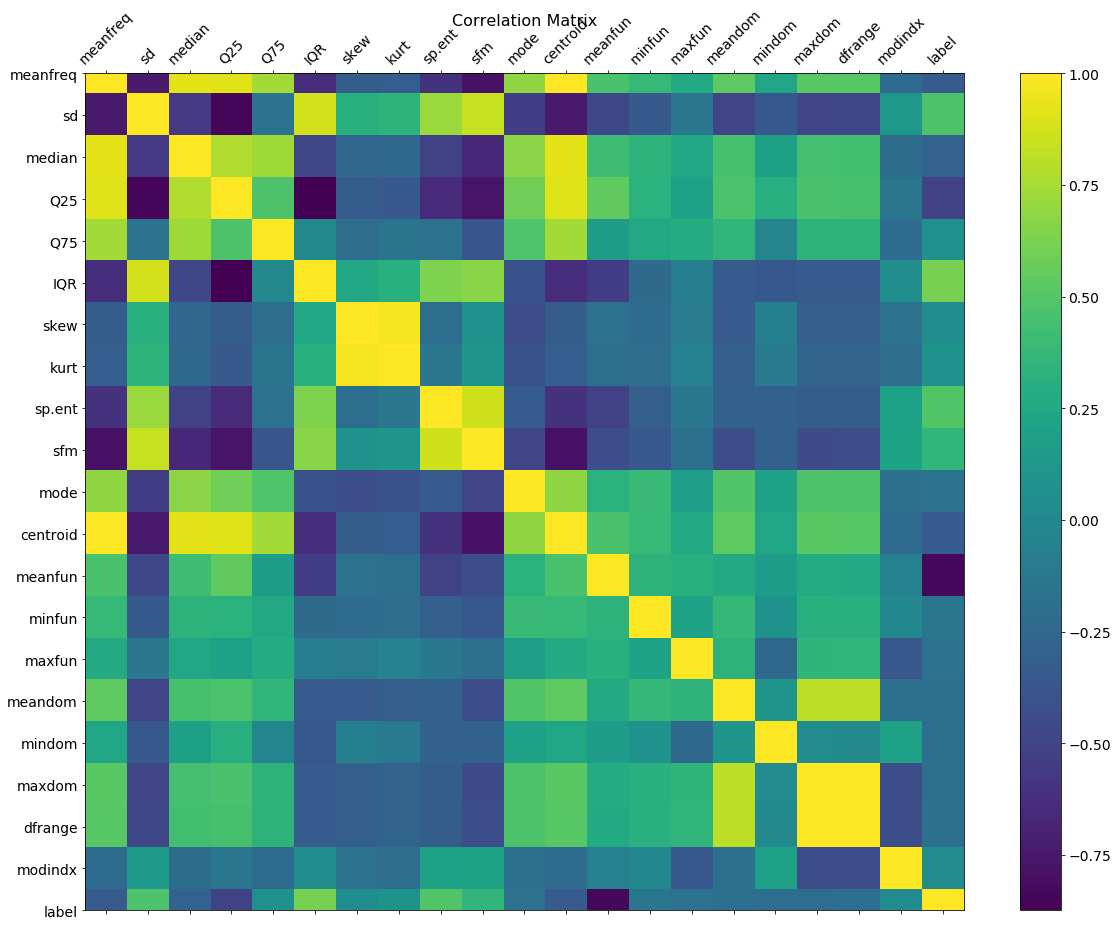

In [94]:
# Plot a correlation matrix
f = plt.figure(figsize=(20, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

## SVM Models <a name="svm"></a>

### Linear Kernel <a name='linear'></a>

In [95]:
# Run SVM with default hyperparameter
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import cross_val_score

svc = SVC() # default hyperparameters
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')

print ('Accuracy score: {:.4f}'.format(metrics.accuracy_score(y_test, y_pred)))
print ('Mean cross validation score: {:.4f}'.format(scores.mean()))

Accuracy score: 0.9763
Mean cross validation score: 0.9665


In [96]:
# Run SVM with linear kernel
svc = SVC(kernel='linear')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')

print ('Accuracy score: {:.4f}'.format(metrics.accuracy_score(y_test, y_pred)))
print ('Mean cross validation score: {:.4f}'.format(scores.mean()))

Accuracy score: 0.9779
Mean cross validation score: 0.9697


### RBF Kernel <a name='rbf'></a>

In [97]:
# Run SVM with RBF (Radial Basis Function) kernel
svc = SVC(kernel='rbf')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')

print ('Accuracy score: {:.4f}'.format(metrics.accuracy_score(y_test, y_pred)))
print ('Mean cross validation score: {:.4f}'.format(scores.mean()))

Accuracy score: 0.9763
Mean cross validation score: 0.9665


### Polynomial Kernel <a name='poly'></a>

In [98]:
# Run SVM with polynomial kernel

svc = SVC(kernel='poly', degree=3)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')

print ('Accuracy score: {:.4f}'.format(metrics.accuracy_score(y_test, y_pred)))
print ('Mean cross validation score: {:.4f}'.format(scores.mean()))

Accuracy score: 0.9590
Mean cross validation score: 0.9451


**Note:** Polynomial kernel's poor performance compared to the other kernels might be due to the fact that it is overfitting the training set.

## Finding Optimal Parameters <a name='finetune'></a>

### Linear Kernel <a name='tune-linear'></a>

In [99]:
# Toying with the C hyperparameter using a linear kernel
# Using a coarse grain of C values
Clist = list (range(1,26))
acc_score = []
for c in Clist:
    svc = SVC(kernel='linear', C=c)
    scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
    acc_score.append(scores.mean())

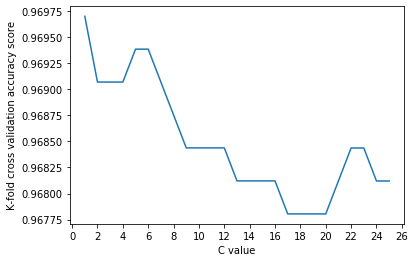

In [100]:
plt.plot(Clist, acc_score)
plt.xticks(np.arange(0,27,2))
plt.xlabel('C value')
plt.ylabel('K-fold cross validation accuracy score')
plt.show();

In [101]:
# Using a fine grain of C values
Clist = list (np.arange(0.1,6,0.1))
acc_score = []
for c in Clist:
    svc = SVC(kernel='linear', C=c)
    scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
    acc_score.append(scores.mean())

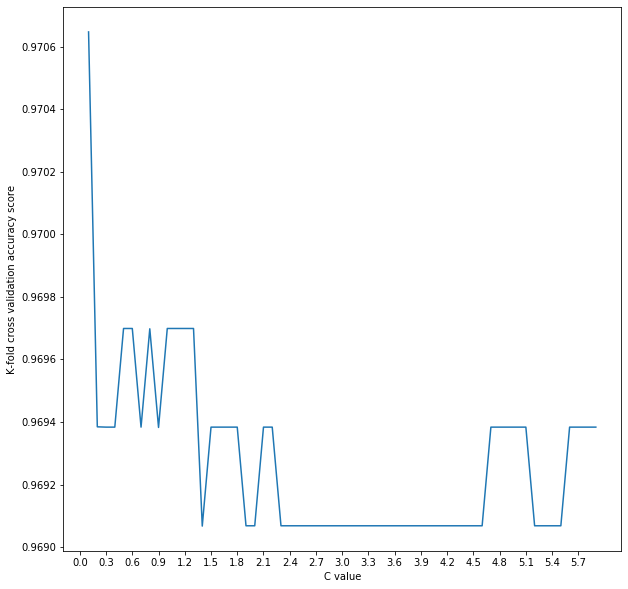

In [102]:
plt.figure(figsize=(10, 10))
plt.plot(Clist, acc_score)
plt.xticks(np.arange(0.0,6,0.3))
plt.xlabel('C value')
plt.ylabel('K-fold cross validation accuracy score')
plt.show();

Thus, using a finer grain for the C hyperparameter, we see that for C = 0.1, we get the highest accuracy score.

### RBF Kernel <a name='tune-rbf'></a>

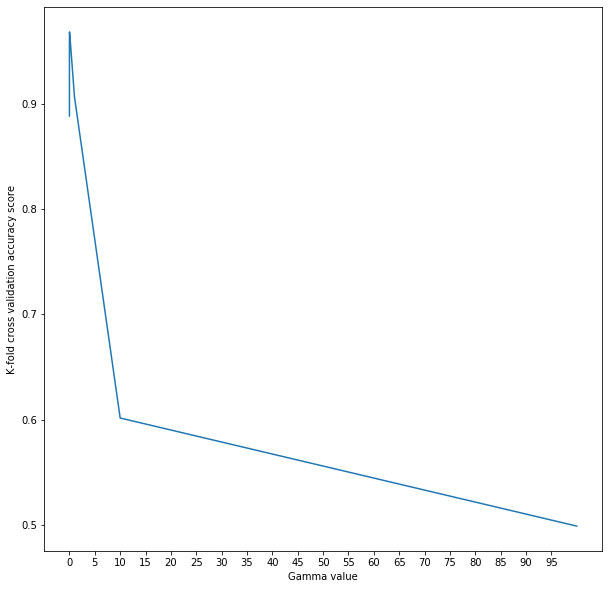

In [103]:
# Toying with the gamma and C hyperparameter using a RBF kernel
# coarse grain
gamma_list = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
acc_score = []
for g in gamma_list:
    svc = SVC(kernel='rbf', gamma=g)
    scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
    acc_score.append(scores.mean())

plt.figure(figsize=(10, 10))
plt.plot(gamma_list, acc_score)
plt.xticks(np.arange(0.0001,100,5))
plt.xlabel('Gamma value')
plt.ylabel('K-fold cross validation accuracy score')
plt.show();

The $\gamma$ hyperparameter is the inverse of the standard deviation, $\sigma$, in the RBF kernel. Thus, increasing $\gamma$ results in decreasing the standard deviation and the boundary function ends up being more irregular and each instance’s range of influence is smaller. Conversely, a small $\gamma$ value results in a larger standard deviation, so instances have a larger range of influence and the decision boundary ends up smoother. 

Thus, gamma acts like a regularization hyperparameter:
* if your model is overfitting, reduce gamma
* if your model is underfitting, increase gamma

similar to the $C$ hyperparameter

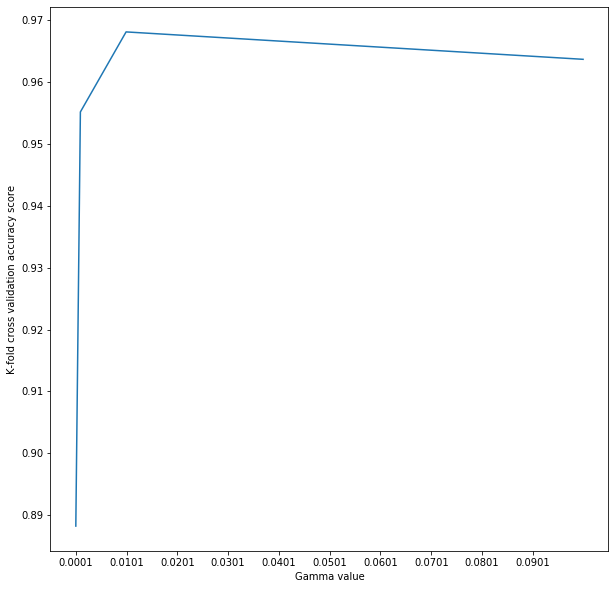

In [104]:
# Toying with the gamma and C hyperparameter using a RBF kernel
# fine grain
gamma_list = [0.0001, 0.001, 0.01, 0.1]
acc_score = []
for g in gamma_list:
    svc = SVC(kernel='rbf', gamma=g)
    scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
    acc_score.append(scores.mean())

plt.figure(figsize=(10, 10))
plt.plot(gamma_list, acc_score)
plt.xticks(np.arange(0.0001,0.1,0.01))
plt.xlabel('Gamma value')
plt.ylabel('K-fold cross validation accuracy score')
plt.show();

Thus, using a finer grain for the $\gamma$ hyperparameter, we see that for $\gamma\sim 0.01$, we get the highest accuracy score.

### Polynomial Kernel <a name='tune-poly'></a>

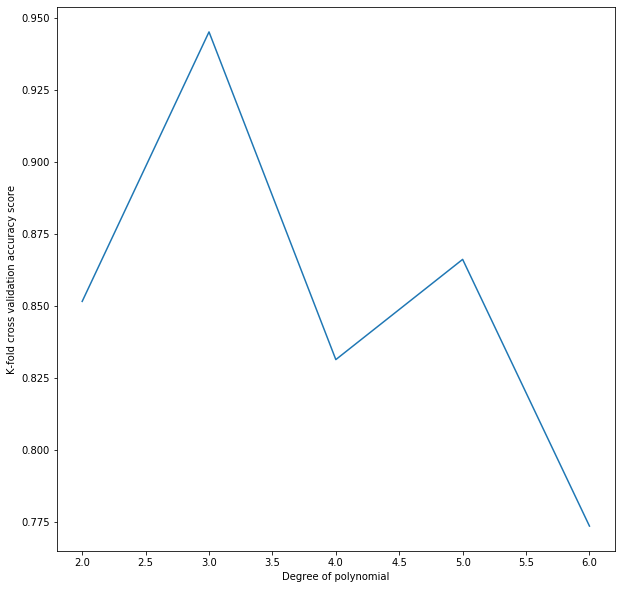

In [105]:
# Toying with the degree hyperparameter and using a polynomial kernel
# coarse grain
degree_list = [2,3,4,5,6]
acc_score = []
for d in degree_list:
    svc = SVC(kernel='poly', degree=d)
    scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
    acc_score.append(scores.mean())

plt.figure(figsize=(10, 10))
plt.plot(degree_list, acc_score)
plt.xlabel('Degree of polynomial')
plt.ylabel('K-fold cross validation accuracy score')
plt.show();

We see that the accuracy score is maximum with degree 3. Higher degrees perform poorly as they overfit the data.

## Optimal Models <a name='optimal'></a>

### Linear Kernel <a name='optimal-linear'></a>

In [106]:
# Now run SVM with new found optimal parameters

# Linear
svc = SVC(kernel='linear', C=0.1)
svc.fit(X_train, y_train)
y_predict = svc.predict(X_test)
accuracy_score = metrics.accuracy_score(y_test, y_predict)

# Linear with K-fold
svc = SVC(kernel='linear', C=0.1)
scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')

print ('Linear kernel accuracy: {:.2f}%'.format(accuracy_score*100))
print ('Linear kernel + K-fold accuracy: {:.2f}%'.format(scores.mean()*100))

Linear kernel accuracy: 97.48%
Linear kernel + K-fold accuracy: 97.06%


Even though the accuracy of the model is slightly better without using K-fold validation, the model may fail to properly generalise on unseen data.

Thus, it is usually a good idea to perform K-fold cross validation.

### RBF Kernel <a name='optimal-rbf'></a>

In [107]:
# RBF
svc = SVC(kernel='rbf', gamma=0.01)
svc.fit(X_train, y_train)
y_predict = svc.predict(X_test)
accuracy_score = metrics.accuracy_score(y_test, y_predict)

# RBF with K-fold
svc = SVC(kernel='rbf', gamma=0.1)
scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')

print ('Linear kernel accuracy: {:.2f}%'.format(accuracy_score*100))
print ('Linear kernel + K-fold accuracy: {:.2f}%'.format(scores.mean()*100))

Linear kernel accuracy: 96.69%
Linear kernel + K-fold accuracy: 96.37%


### Polynomial Kernel <a name='optimal-poly'></a>

In [108]:
# Polynomial
svc = SVC(kernel='poly', degree=3)
svc.fit(X_train, y_train)
y_predict = svc.predict(X_test)
accuracy_score = metrics.accuracy_score(y_test, y_predict)

# Linear with K-fold
svc = SVC(kernel='poly', degree=3)
scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')

print ('Linear kernel accuracy: {:.2f}%'.format(accuracy_score*100))
print ('Linear kernel + K-fold accuracy: {:.2f}%'.format(scores.mean()*100))

Linear kernel accuracy: 95.90%
Linear kernel + K-fold accuracy: 94.51%


## Grid Search <a name='grid'></a>

We will now use the grid search technique that will find us the best model with the best hyperparameters. We shall see that this technique is a lot quicker than our individual analyses before and gives us the same result.

In [109]:
# Use grid search method to find the best parameters
tuned_params = {
    'C'     : (np.arange(0.0,1.1,0.1)),
    'gamma' : (np.arange(0.00,0.06,0.01)),
    'degree': (np.arange(0,5,1)),
    'kernel': ['linear', 'rbf', 'poly'],
}

In [110]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
from sklearn.model_selection import GridSearchCV

model = GridSearchCV (svc, tuned_params, cv=10, scoring='accuracy')

In [111]:
model.fit(X_train, y_train)
print (model.best_score_)

0.9814556036226696


In [112]:
print (model.best_params_)

{'C': 0.9, 'degree': 0, 'gamma': 0.05, 'kernel': 'rbf'}


In [113]:
y_pred = model.predict(X_test)
print ('Accuracy: {:.2f}%'.format(metrics.accuracy_score(y_pred, y_test)*100))

Accuracy: 97.79%


### Summary <a name='summary'></a>

In this notebook, we first ran basic version of various svm kernels. We next fine-tuned the parameters of each kernel to find the parameters that gives us the highest accuracy on our dataset. Finally, we also ran a grid search technique which basically replaces the steps of finding of optimal parameters.

We see that the RBF Kernel with $C=0.9$ and $\gamma=0.05$ gives us the best model. Since we have used K-fold cross validation, our model generalized to new data correctly which we can see from our prediction accuracy of $\sim 98\%$.